# Load pre-trained CLGP model, and evaluate on test set.

# Imports

In [ ]:
!pip install scikit-learn
!pip install plotly

In [1]:
import os
#import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
#import albumentations as A
import torch
from torch import nn
import torch.nn.functional as F
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from transformers import AutoTokenizer, AutoModel
import triton
import logging
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.manifold
import plotly.express as px
from umap import UMAP

/tmp/ipykernel_12/4195018638.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Config

In [3]:
import os
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'datasets', 'refseq')
save_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output', 'clip')
class CFG:
    debug = False
    save_path = save_path
    train_data = os.path.join(data_path, "train_captions.csv")
    test_data = os.path.join(data_path, "test_captions.csv")
    sequence_path = os.path.join(data_path, "test.fa") # TODO
    captions_path = os.path.join(data_path, "sequence_captions_test_space.json")
    batch_size = 16
    num_workers = 4
    head_lr = 1e-3
    nucleotide_encoder_lr = 1e-5
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "immanuelabdi/DNABERT-2-117M"
    nucleotide_embedding = 768
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200
    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0
    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

# Utils

In [4]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [5]:
from huggingface_hub import login
import transformers

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [7]:
tokenizer = AutoTokenizer.from_pretrained("immanuelabdi/DNABERT-2-117M",
                                          trust_remote_code=True)
model = AutoModel.from_pretrained("immanuelabdi/DNABERT-2-117M",
                                  trust_remote_code=True)
model = transformers.AutoModelForSequenceClassification.from_pretrained("immanuelabdi/DNABERT-2-117M",
        num_labels=56,
        trust_remote_code=True,
    )

tokenizer_config.json: 100%|██████████| 158/158 [00:00<00:00, 596kB/s]
tokenizer.json: 100%|██████████| 168k/168k [00:00<00:00, 1.60MB/s]
config.json: 100%|██████████| 862/862 [00:00<00:00, 3.85MB/s]
configuration_bert.py: 100%|██████████| 1.02k/1.02k [00:00<00:00, 2.77MB/s]
A new version of the following files was downloaded from https://huggingface.co/immanuelabdi/DNABERT-2-117M:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
bert_layers.py: 100%|██████████| 40.8k/40.8k [00:00<00:00, 681kB/s]
flash_attn_triton.py: 100%|██████████| 43.2k/43.2k [00:00<00:00, 89.3MB/s]
A new version of the following files was downloaded from https://huggingface.co/immanuelabdi/DNABERT-2-117M:
- flash_attn_triton.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
bert_padding.py:

KeyboardInterrupt: 

In [6]:
class ProjectionHead(nn.Module):
    def __init__(
            self,
            embedding_dim,
            projection_dim=CFG.projection_dim,
            dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
        for p in self.model.parameters():
            p.requires_grad = trainable
        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output[0]
        return last_hidden_state[:, self.target_token_idx, :]

In [8]:
class NucleotideEncoder(nn.Module):
    def __init__(self, model_name=CFG.model_name,
                 trainable=CFG.trainable):
        super().__init__()
        logging.info("Loading DNABERT2.  Note, this is using a custom version of DNABERT2 that is not available on HuggingFace."
                     "use the model_name 'immanuelabdi/DNABERT-2-117M'")
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output[0]
        return last_hidden_state[:, self.target_token_idx, :]

In [61]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self,
                 sequences,
                 captions,
                 tokenizer_sequence,
                 tokenizer_captions):
        """
        sequence_filenames and cpations must have the same length.
        """
        self.sequences = sequences
        self.captions = captions
        self.encoded_sequences = tokenizer_sequence(
            list(sequences), padding=True, truncation=True, max_length=300
        )
        self.encoded_captions = tokenizer_captions(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )

    def __getitem__(self, idx):
        item_nucleotide = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_sequences.items()
        }
        item_caption = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        return {
            "input_ids_nucleotide": item_nucleotide["input_ids"],
            "attention_mask_nucleotide": item_nucleotide["attention_mask"],
            "input_ids_text": item_caption["input_ids"],
            "attention_mask_text": item_caption["attention_mask"],
            "captions": self.captions[idx]
        }

    def __len__(self):
        return len(self.captions)

In [10]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()
    
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        nucleotide_embedding=CFG.nucleotide_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.nucleotide_encoder = NucleotideEncoder(CFG.model_name, CFG.trainable)
        self.text_encoder = TextEncoder()
        self.nucleotide_projection = ProjectionHead(embedding_dim=nucleotide_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting nucleotide and Text Features
        nucleotide_features = self.nucleotide_encoder(
            input_ids=batch["input_ids_nucleotide"], attention_mask=batch["attention_mask_nucleotide"]
        )
        text_features = self.text_encoder(
            input_ids=batch["input_ids_text"], attention_mask=batch["attention_mask_text"]
        )
        # Getting nucleotide and Text Embeddings (with same dimension)
        nucleotide_embeddings = self.nucleotide_projection(nucleotide_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ nucleotide_embeddings.T) / self.temperature
        nucleotide_similarity = nucleotide_embeddings @ nucleotide_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (nucleotide_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        nucleotide_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (nucleotide_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

In [11]:
def build_loaders(dataframe, 
                  tokenizer_nucleotide, 
                  tokenizer_caption,
                  mode):
    dataset = CLIPDataset(
        dataframe["sequence"].values,
        dataframe["caption"].values,
        tokenizer_nucleotide,
        tokenizer_caption,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [18]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["input_ids_nucleotide"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["input_ids_nucleotide"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    int_df= pd.read_csv(CFG.train_data, dtype={"sequence": str, "caption": str}) 
    train_df, valid_df = train_test_split(int_df,
                                          test_size=0.03)
    logging.info('Building Tokenizers')
    tokenizer_captions = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer_nucleotide = AutoTokenizer.from_pretrained(CFG.model_name)
    logging.info('Building DataLoaders')
    train_loader = build_loaders(train_df, 
                                 tokenizer_nucleotide, 
                                 tokenizer_captions, mode="train")
    valid_loader = build_loaders(valid_df, 
                                 tokenizer_nucleotide, 
                                 tokenizer_captions, mode="valid")
    logging.info('Building Model')
    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.nucleotide_encoder.parameters(), "lr": CFG.nucleotide_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.nucleotide_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    # evaluate
    model.load_state_dict(torch.load('best.pt'))
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    optimizer.load_state_dict(torch.load('best.pt'))
    
#    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
#    )
#    step = "epoch"
#
#    best_loss = float('inf')
#    logging.info('Starting Training')
#    for epoch in range(CFG.epochs):
#        print(f"Epoch: {epoch + 1}")
#        model.train()
#        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
#        model.eval()
#        with torch.no_grad():
#            valid_loss = valid_epoch(model, valid_loader)
#        
#        if valid_loss.avg < best_loss:
#            best_loss = valid_loss.avg
#            torch.save(model.state_dict(), "best.pt")
#            print("Saved Best Model!")
#        
#       lr_scheduler.step(valid_loss.avg)
    

In [13]:
main()

vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 3.53MB/s]
tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 121kB/s]
tokenizer_config.json: 100%|██████████| 158/158 [00:00<00:00, 830kB/s]
tokenizer.json: 100%|██████████| 168k/168k [00:00<00:00, 2.76MB/s]
config.json: 100%|██████████| 862/862 [00:00<00:00, 5.30MB/s]
configuration_bert.py: 100%|██████████| 1.02k/1.02k [00:00<00:00, 5.61MB/s]
A new version of the following files was downloaded from https://huggingface.co/immanuelabdi/DNABERT-2-117M:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
bert_layers.py: 100%|██████████| 40.8k/40.8k [00:00<00:00, 106MB/s]
flash_attn_triton.py: 100%|██████████| 43.2k/43.2k [00:00<00:00, 722kB/s]
A new version of the following files was downloaded from https://huggingface.co/immanuelabdi/DNABERT-2-117M:
- flash_attn_triton.py
. Make sure to double-check they

In [ ]:
int_df= pd.read_csv(CFG.train_data, dtype={"sequence": str, "caption": str}) 
train_df, valid_df = train_test_split(int_df,
                                      test_size=0.03)
logging.info('Building Tokenizers')
tokenizer_captions = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
tokenizer_nucleotide = AutoTokenizer.from_pretrained(CFG.model_name)
logging.info('Building DataLoaders')
train_loader = build_loaders(train_df, 
                             tokenizer_nucleotide, 
                             tokenizer_captions, mode="train")
valid_loader = build_loaders(valid_df, 
                             tokenizer_nucleotide, 
                             tokenizer_captions, mode="valid")
logging.info('Building Model')
model = CLIPModel().to(CFG.device)
params = [
    {"params": model.nucleotide_encoder.parameters(), "lr": CFG.nucleotide_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
    {"params": itertools.chain(
        model.nucleotide_projection.parameters(), model.text_projection.parameters()
    ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
]
# evaluate
optimizer = torch.optim.AdamW(params, weight_decay=0.)
checkpoint = torch.load('best.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Evaluate CLGP

In [114]:
def get_nucleotide_embeddings(test_data_path, model_path):
    test_data = os.path.join(data_path, "test_captions.csv")
    valid_df = pd.read_csv(test_data, dtype={"sequence": str, "caption": str})
    tokenizer_nucleotide = AutoTokenizer.from_pretrained(CFG.model_name)
    tokenizer_text = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    
    valid_loader = build_loaders(valid_df, 
                                 tokenizer_nucleotide, 
                                 tokenizer_text,
                                 mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    captions = []
    valid_nucleotide_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            nucleotide_features = model.nucleotide_encoder(input_ids=batch["input_ids_nucleotide"].to(CFG.device), 
                                                           attention_mask=batch["attention_mask_nucleotide"].to(CFG.device))
            nucleotide_embeddings = model.nucleotide_projection(nucleotide_features)
            valid_nucleotide_embeddings.append(nucleotide_embeddings)
            captions.append(batch['captions'])
    captions = [item for sublist in captions for item in sublist]
    return model, torch.cat(valid_nucleotide_embeddings), captions

In [62]:
def get_caption_embeddings(test_data_with_example, model_path):
    valid_df = test_data_with_example
    tokenizer_nucleotide = AutoTokenizer.from_pretrained(CFG.model_name)
    tokenizer_text = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    
    valid_loader = build_loaders(valid_df, 
                                 tokenizer_nucleotide, 
                                 tokenizer_text,
                                 mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    valid_text_embeddings = []
    captions = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            text_features = model.text_encoder(input_ids=batch["input_ids_text"].to(CFG.device), 
                                               attention_mask=batch["attention_mask_text"].to(CFG.device))
            text_embeddings = model.text_projection(text_features)
            valid_text_embeddings.append(text_embeddings)
            captions.append(batch['captions'])
    # flatten captions
    captions = [item for sublist in captions for item in sublist]
    return model, torch.cat(valid_text_embeddings), captions

In [ ]:
test_data = pd.read_csv(CFG.test_data, dtype={"sequence": str, "caption": str})
model, caption_embeddings, test_captions = get_caption_embeddings(test_data.groupby('caption').head(1), 'best.pt')
caption_embeddings = caption_embeddings.cpu().numpy()
# flatten captions if not already flattened
if len(test_captions) > 0 and isinstance(test_captions[0], list):
    test_captions = [item for sublist in test_captions for item in sublist]
    df_caption_embeddings = pd.DataFrame(caption_embeddings, 
                                     index=test_captions)

In [ ]:
model, nucleotide_embeddings, nucleotide_captions = get_nucleotide_embeddings('hi', 'best.pt')
nucleotide_embeddings = nucleotide_embeddings.cpu().numpy()
df_nucleotide_embeddings = pd.DataFrame(nucleotide_embeddings, 
                                        index=nucleotide_captions)

In [226]:
test_captions

['Apicomplexa',
 'Candidatus Thermoplasmatota',
 'Bacillariophyta',
 'Nematoda',
 'Cyanobacteriota',
 'Aquificota',
 'Thermoproteota',
 'Peploviricota',
 'Negarnaviricota',
 'Bacteroidota',
 'Chordata',
 'Fusobacteriota',
 'Nitrospirota',
 'Pisuviricota',
 'Basidiomycota',
 'Mycoplasmatota',
 'Artverviricota',
 'Bacillota',
 'Kitrinoviricota',
 'Thermotogota',
 'Chlorophyta',
 'Chlamydiota',
 'Actinomycetota',
 'Rhodothermota',
 'Lentisphaerota',
 'Chloroflexota',
 'Verrucomicrobiota',
 'Deinococcota',
 'Mollusca',
 'Euryarchaeota',
 'Ascomycota',
 'Rhodophyta',
 'Arthropoda',
 'unclassified',
 'Myxococcota',
 'Euglenozoa',
 'Nitrososphaerota',
 'Pseudomonadota',
 'Chlorobiota',
 'Streptophyta',
 'Platyhelminthes',
 'Thermodesulfobacteriota',
 'Spirochaetota',
 'Gemmatimonadota',
 'Uroviricota',
 'Taleaviricota',
 'Evosea',
 'Planctomycetota',
 'Synergistota',
 'Acidobacteriota',
 'Bdellovibrionota',
 'Ciliophora',
 'Elusimicrobiota',
 'Kiritimatiellota',
 'Deferribacterota',
 'Campylo

# Find the nearest caption neighbors for each nucleotide embedding

In [126]:
def find_nearest_neighbor(embedding, embeddings, captions):
    """
    Find the nearest neighbor of an embedding from a list of embeddings.
    """
    distances = cdist([embedding], embeddings)
    idx = np.argmin(distances)
    return captions[idx]

In [232]:
logits = df_nucleotide_embeddings.apply(lambda x: find_nearest_neighbor(x, caption_embeddings, test_captions), axis=1)
df_metric = logits.reset_index()
df_metric.columns = ['label', 'logit']

In [213]:
mask = df_metric['label'] == df_metric['logit']

In [ ]:
# Get only nucleotide embeddings that are true
df_nucleotide_embeddings_true = df_nucleotide_embeddings.reset_index()[mask].reset_index(drop=True)
df_nucleotide_embeddings_true.index = df_nucleotide_embeddings_true['index']
df_nucleotide_embeddings_true = df_nucleotide_embeddings_true.drop('index', axis=1)

In [234]:
logits_caption = df_caption_embeddings.apply(lambda x: find_nearest_neighbor(x, df_nucleotide_embeddings_true, df_nucleotide_embeddings_true.index), axis=1)
df_metrics_caption = logits_caption.reset_index()
df_metrics_caption.columns = ['label', 'logit']

## Test set metrics

In [177]:
import numpy as np

In [233]:
print('Metrics for test set sequence embeddings classification')
print(f'accuracy: {metrics.accuracy_score(df_metric["label"], df_metric["logit"])}')
print(f'f1: {metrics.f1_score(df_metric["label"], df_metric["logit"], average="weighted", labels=np.unique(df_metric["logit"]))}')
print(f'precision: {metrics.precision_score(df_metric["label"], df_metric["logit"], average="macro", zero_division=0)}')
print(f'recall: {metrics.recall_score(df_metric["label"], df_metric["logit"], average="macro", zero_division=0)}')

Metrics for test set sequence embeddings classification
accuracy: 0.4945660611706257
f1: 0.6289700292429894
precision: 0.6491926768829943
recall: 0.5214665426755843


In [235]:
print('Metrics for test set caption embeddings classification')
print(f'accuracy: {metrics.accuracy_score(df_metrics_caption["label"], df_metrics_caption["logit"])}')
print(f'f1: {metrics.f1_score(df_metrics_caption["label"], df_metrics_caption["logit"], average="macro", zero_division=0)}')
print(f'precision: {metrics.precision_score(df_metrics_caption["label"], df_metrics_caption["logit"], average="macro", zero_division=0)}')
print(f'recall: {metrics.recall_score(df_metrics_caption["label"], df_metrics_caption["logit"], average="macro", zero_division=0)}')

Metrics for test set caption embeddings classification
accuracy: 0.17857142857142858
f1: 0.0971916971916972
precision: 0.08204104010025061
recall: 0.17857142857142858


In [166]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for numba>=0.51.2 from https://files.pythonhosted.org/packages/ed/13/b66627125b35f2987bd9872cf028b5e1e1ffcbc8d1e182ac4e84eed3998f/numba-0.58.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/4e/82/0b9851a2fd4da9b57d7931446f5ebab92a98f1f35d3dc0dae5f9ed50a462/pynndescent-0.5.11-py3-none-any.whl.metadata
  Obtaining dependency information for llvmlite<0.42,>=0.41.0dev0 from https://files.pythonhoste

In [257]:

#tsne = sklearn.manifold.TSNE(n_components =2, random_state=0)
#projections = tsne.fit_transform(nucleotide_embeddings)
umap_2d = UMAP(n_components=2, random_state=0)
#projections = umap_2d.fit_transform(nucleotide_embeddings)
fig = px.scatter(
    projections, x=0, y=1,
    width=1000, height=800,
    color=nucleotide_captions
)
fig.update_layout(legend=dict(yanchor='bottom', xanchor='center', y=-0.5, x=0.5, orientation='h'))
fig.show()
#save as png
fig.write_image(os.path.join(save_path, 'umap_nucleotide_embeddings.png'))

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [256]:
!pip install -U kaleido

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.5 MB/s eta 0:00:00:00:0100:01


## Confusion Matrix

In [237]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib!=3.6.1,>=3.3 from https://files.pythonhosted.org/packages/19/e5/a4ea514515f270224435c69359abb7a3d152ed31b9ee3ba5e63017461945/matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/58/56/e2c43dcfa1f9c7db4d5e3d6f5134b24ed953f4e2133a4b12f0062148db58/contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_6

In [247]:
!pip install pandas_ml

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.6 MB/s eta 0:00:00


In [238]:
import seaborn as sns
import matplotlib.pyplot as plt


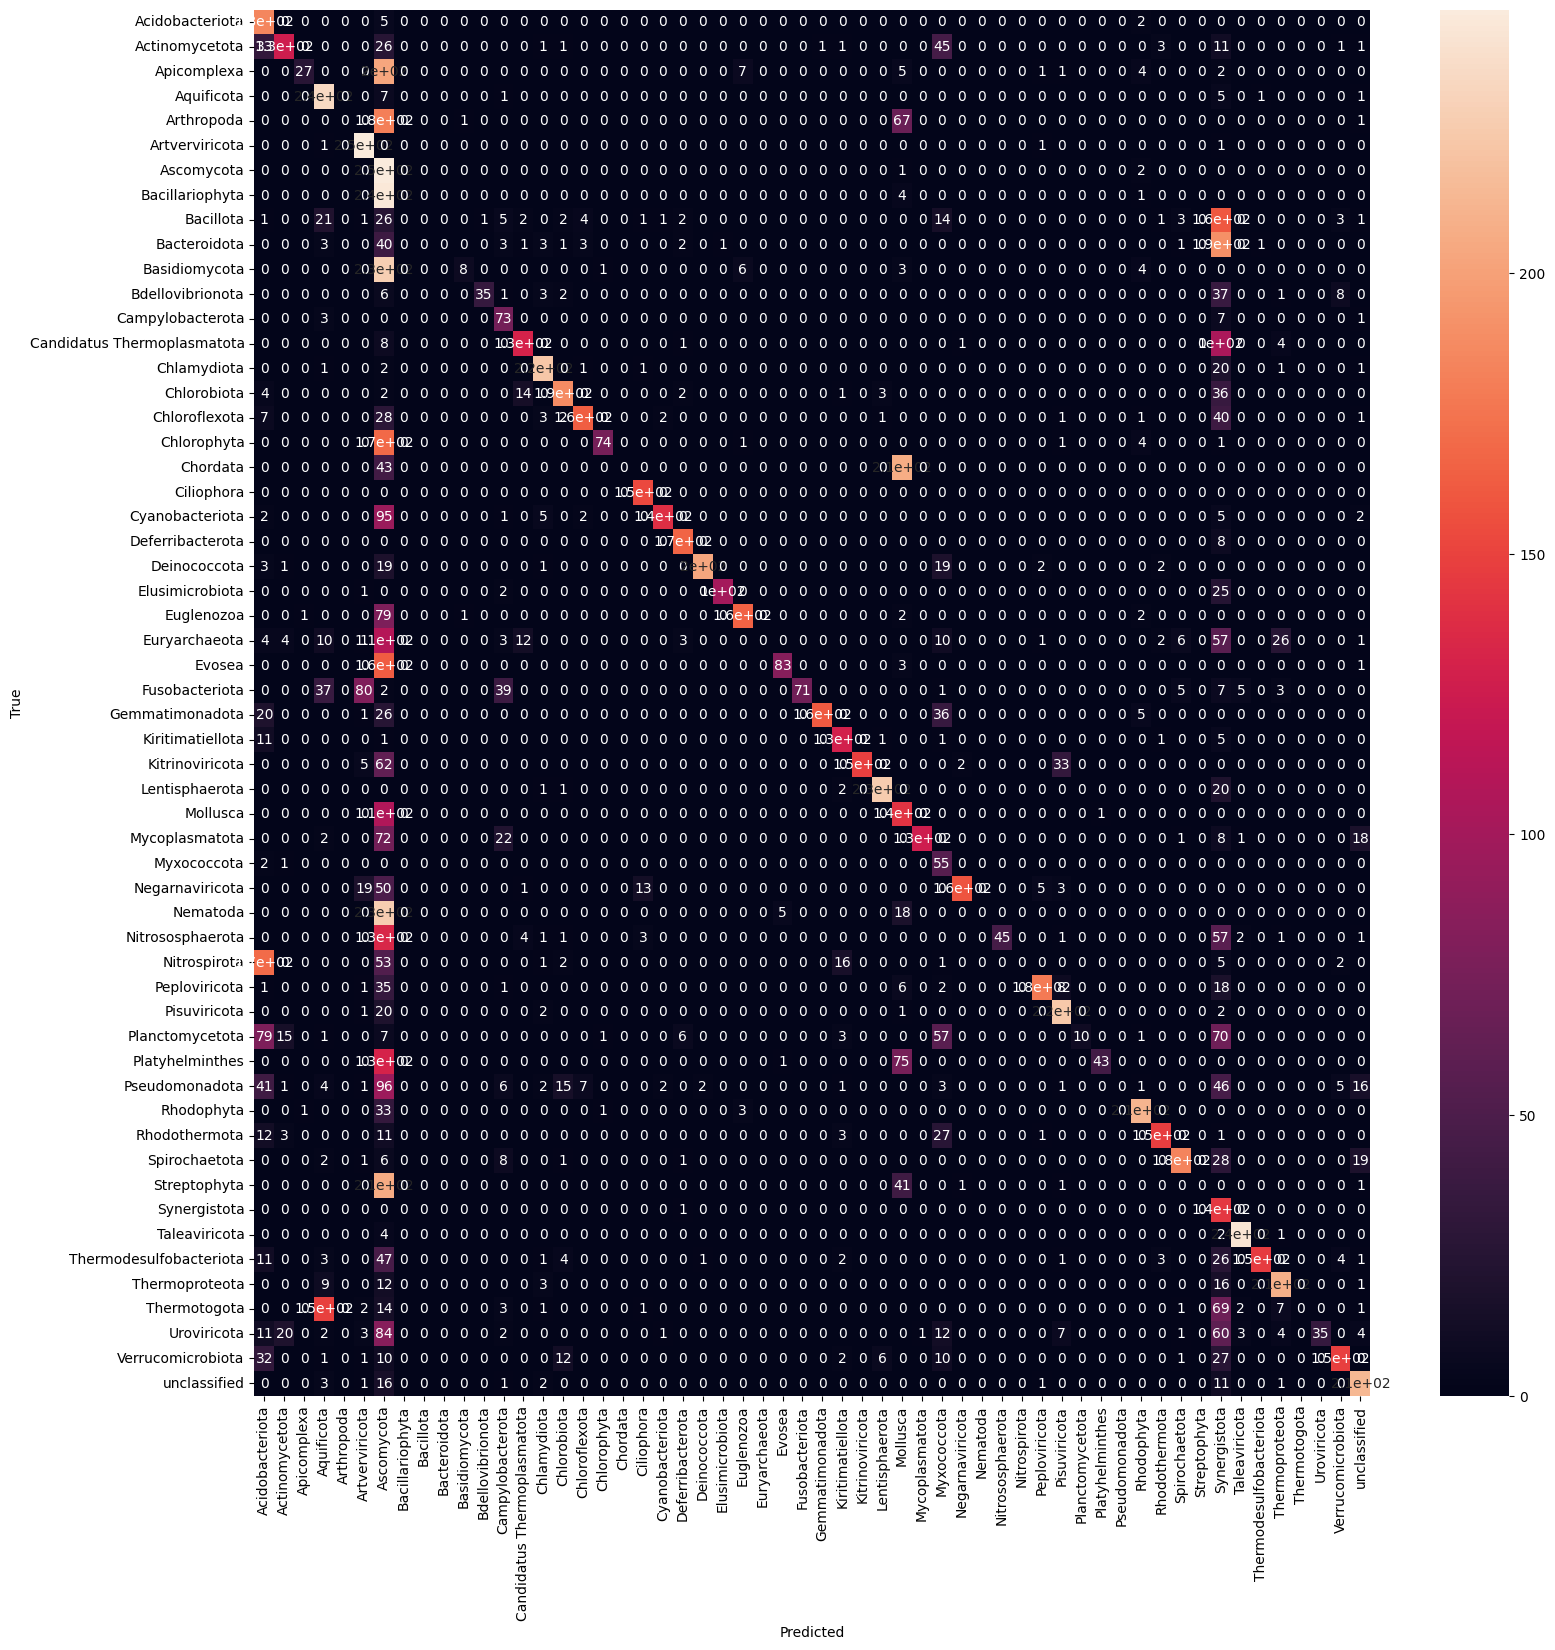

In [252]:
cm = sklearn.metrics.confusion_matrix(df_metric['label'], df_metric['logit'], labels=np.unique(df_metric['label']))
cm =pd.DataFrame(cm, index=np.unique(df_metric['label']), columns=np.unique(df_metric['label']))
plt.figure(figsize=(18,18))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [102]:
#test_captions_flattened = [item for sublist in test_captions for item in sublist]
df_caption_embeddings = pd.DataFrame(caption_embeddings.cpu().numpy(), 
                                     index=[item for sublist in test_captions for item in sublist])

In [85]:
# Find the nearest caption neighbors for each nucleotide embedding
nucleotide_embedding_example = nucleotide_embeddings[0]


#Processing data: for later

In [ ]:
import json
import pandas as pd
def intake_fasta_data(file_path:str) -> pd.DataFrame:
    """
    Intakes fasta file and returns a list of tuples containing the sequence id and the sequence itself
    Args:
        file_path (str): path to fasta file
    Returns:
        
    """
    with open(file_path, 'r') as f:
        data = [i.rstrip() for i in f.readlines()]
    fasta = []
    for idx in range(len(data)):
        if idx % 2 == 1:
            fasta.append({"id": data[idx-1][1:], 
                          "sequence": data[idx]})
    return pd.DataFrame(fasta)

def intake_json_data(file_path:str) -> pd.DataFrame:
    """
    Intakes json file consisting of a list of dictionaries
    with each dictionary containing a key "sequence" representing id
    and a key "caption" representing the taxa.
    Returns a dataframe containing the sequence id and the sequence itself
    Args:
        file_path (str): path to json file
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df.columns = ['id', 'sequence']
    return df


In [ ]:
# Join df_fasta and df_json
def merge_fasta_json(fasta_path:str, 
                     json_path:str) -> pd.DataFrame:
    """
    Intakes fasta file of sequences with headers of taxids
    and a json file with keys "sequence" and "caption" representing
    the "{taxid} {index}" and the taxa itself.
    Returns a dataframe containing the taxa and the sequence
    """
    df_fasta = intake_fasta_data(fasta_path)
    df_json = intake_json_data(json_path)
    df = df_json.merge(df_fasta, on='id', how='left').drop('id', axis=1).rename(columns={'sequence_y': 'sequence', 'sequence_x': 'caption'})
    return df

In [ ]:
df_test = merge_fasta_json(CFG.sequence_path, 
                           CFG.captions_path)
df_test.to_csv(os.path.join(data_path,'test_captions.csv'), index=False)
#For training data
captions_path_train = os.path.join(data_path, "sequence_captions_train_space.json")
sequence_path_train = os.path.join(data_path, "train.fa")
df_train = merge_fasta_json(sequence_path_train, captions_path_train)

In [ ]:
df_train.to_csv(os.path.join(data_path,'train_captions.csv'), index=False)

In [ ]:
def get_label_mapper(train, test):
    """
    Returns a dictionary mapping labels to integers, using both the train and test sets.
    """
    mapper = {}
    unique_labels_train = list(df_train['caption'].unique())
    unique_labels_test = list(df_test['caption'].unique())
    curr_label = 0
    for dataset in [unique_labels_train, unique_labels_test]:
        for label in dataset:
            if label not in mapper:
                mapper[label] = curr_label
                curr_label += 1
    return mapper

In [22]:
mapping_label = get_label_mapper(df_train, df_test)

In [24]:
df_test['label'] = df_test['caption'].map(mapping_label)
df_train['label'] = df_train['caption'].map(mapping_label)


In [ ]:
if os.path.exists(os.path.join(data_path, 'train_captions.csv')):
    df_train = pd.read_csv(os.path.join(data_path, 'train_captions.csv'))
else:
    captions_path_train = os.path.join(data_path, "sequence_captions_train_space.json")
    sequence_path_train = os.path.join(data_path, "train.fa")
    df_train = merge_fasta_json(sequence_path_train, captions_path_train)
    df_train.to_csv(os.path.join(data_path,'train_captions.csv'), index=False)

In [28]:
df_train[['sequence', 'caption']].to_csv(os.path.join(data_path, 'train_captions.csv'), index=False)
df_test[['sequence', 'caption']].to_csv(os.path.join(data_path, 'test_captions.csv'), index=False)
df_train[['sequence', 'label']].to_csv(os.path.join(data_path, 'train.csv'), index=False)
df_test[['sequence', 'label']].to_csv(os.path.join(data_path, 'test.csv'), index=False)
with open(os.path.join(data_path, 'mapping_label.json'), 'w') as f:
    json.dump(mapping_label, f)

In [39]:
!pip install graphviz torchview


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.1 MB/s eta 0:00:00
